In [ ]:
#import lines
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time as timer
from sklearn.metrics import accuracy_score

**Question 1**

Build a neural network using PyTorch to predict the median housing price for the housing.csv data found at https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/housing.csv with cmedv being the target.


You can use any methods that you want as long as they are correct (e.g. if you fit a scaler on the testing data that is incorrect).


You may use NumPy, Pandas, PyTorch, scikit-learn (if you deem it necessary), and matplotlib (if you deem it necessary).

You should achieve a 5-fold KFold cross-validated MSE below 10.

In [ ]:
#read in the data
url = 'https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/housing.csv'
data = pd.read_csv(url)
data.head()

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001


In [ ]:
#drop the non numeric columns: town and river
housing_data = data.drop(columns = ['town', 'river'])

#set the x variables to be the rest of the columns (dropping median housing price)
X = housing_data.drop(columns=['cmedv']).values.astype(np.float32)
#set the target variable to be median housing price (cmedv)
y = housing_data['cmedv'].values.astype(np.float32).reshape(-1,1)

In [ ]:
def make_loader(X, y, batch_size=32, shuffle=True):
    #creating a data loader for the dataset
    housing_data = TensorDataset(torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32)))
    return DataLoader(housing_data, batch_size=batch_size, shuffle=shuffle)

def seconds_to_time(seconds, format='HMS'):
  '''Convert seconds to a string in the format HHh MMm SSs or MMm SSs or SSs'''
  if format == 'HMS':
    hours = int((seconds % 86400) // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}h {minutes:02}m {seconds:02}s"
  elif format == 'MS':
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}m {seconds:02}s"
  elif format == 'S':
    seconds = int(seconds % 60)
    return f"{seconds:02}s"

In [ ]:
#model definition
class RegressionNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            #this defines the structure of forward propagation: input data passes through multiple layers to generate an output
            nn.Linear(in_dim, 128), #layer 1, made a deeper model
            nn.ReLU(), #activation function 1
            nn.Linear(128, 64), #layer 2
            nn.ReLU(), #activation function 2
            nn.Linear(64,32), #layer 3
            nn.ReLU(), #activation function 3
            nn.Linear(32, 1) #output layer
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
#set and display the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:' , {device})

#format
num_dashes = 50 #number of dashes to print

#set the hyperparameters
batch_size = 40 #batch size
num_epochs = 410 #number of epochs
learning_rate = 1e-3 #learning rate
min_lr = 1e-8 #minimum learning rate for CosineAnnealingLR
weight_decay = .01 #weight decay, set to None or 0 if not used
num_folds = 5 #number of folds for KFold cross-validation
val_percent = 0.26 #percentage of training data to use for validation
display_every = 100 #display every N epochs

#initial printouts
print(f'Batch size: {batch_size}')
print(f'Number of epochs: {num_epochs}')
print(f'Learning rate: {learning_rate}')
print(f'Weight decay: {weight_decay}')
print(f'Number of folds: {num_folds}')
print(f'Train Portion: {100*(1 - 1/num_folds)*(1-val_percent):.2f}%')
print(f'Validation Portion: {100*(1 - 1/num_folds)*val_percent:.2f}%')
print(f'Test Portion: {100*1/num_folds:.2f}%')
print('-'*num_dashes + '\n')

#setup storage for the output
foldwise_history = []
model_history = {}

kf = KFold(n_splits=num_folds, shuffle=True)

#looping through every fold
tstart = timer.time()
for i, (trainval_idx, test_idx) in enumerate(kf.split(X)):
    #print fold number
    print(f'\nFold [{i+1}/{num_folds}]')
    print('-'*num_dashes)

    #split data into training/val and testing sets
    X_trainval, X_test = X[trainval_idx], X[test_idx]
    y_trainval, y_test = y[trainval_idx], y[test_idx]

    #split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_percent, shuffle=True)

    #scale data, only fitting on training not validation or test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    #create DataLoaders for training, validation and testing sets
    train_loader = make_loader(X_train, y_train, batch_size = batch_size, shuffle = True)
    val_loader = make_loader(X_val, y_val, batch_size = batch_size, shuffle = False)
    test_loader = make_loader(X_test, y_test, batch_size = batch_size, shuffle = False)

    #create model and move to device
    model = RegressionNet(in_dim = X.shape[1]).to(device)

    #setup loss function and optimizer
    criterion = nn.MSELoss() #loss function
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min = min_lr) #learning rate scheduler

    #Setup fold history storage
    fold_history = {
        'train_loss': [], #training loss
        'val_loss': [], #validation loss
        'lr': [], #learning rate
    }

    #training loop
    for epoch in range(num_epochs):
        ta = timer.time() #start the timer for epoch
        model.train() #set model to training model
        train_loss = 0.0

        #loop through each batch in the training set
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) #put data on device (GPU/CPU)
            optimizer.zero_grad() #zero the gradients
            outputs = model(batch_X) #forward pass, predict output
            batch_train_loss = criterion(outputs, batch_y) #compute loss
            batch_train_loss.backward() #backpropagation, compute gradients
            optimizer.step() #update weights
            train_loss += batch_train_loss.item()*len(batch_X) #add batch loss to training loss, weight by batch size (Important if not all batches are same size)
        scheduler.step() #update learning rate

        #results of training for the epoch
        train_loss /= len(train_loader.dataset) #divide by number of samples to get average loss
        fold_history['train_loss'].append(train_loss) #store training loss
        fold_history['lr'].append(optimizer.param_groups[0]['lr']) #store learning rate

        #validation loop
        model.eval() #set model to evaluation mode (doesnt update weights)
        val_loss = 0.0

        with torch.no_grad(): #no gradients are computed here
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                batch_val_loss = criterion(outputs, batch_y)
                val_loss += batch_val_loss.item()*len(batch_X)

        #results of validation for the epoch
        val_loss /= len(val_loader.dataset)
        fold_history['val_loss'].append(val_loss)
        tb = timer.time() #end time for epoch

        #time operations
        this_epoch_time = tb - ta #time taken for this epoch
        time_elapsed = tb - tstart #total time elapsed since start of training
        avg_epoch_time = time_elapsed/((epoch + 1) + i*num_epochs) #average time per epoch
        time_remaining = avg_epoch_time*((num_epochs - (epoch + 1)) + (num_folds - 1 - i)*num_epochs) #estimated time remaining for training

        #convert to strings for display
        str_time_elapsed = seconds_to_time(time_elapsed, format='HMS') #convert to string
        str_time_remaining = seconds_to_time(time_remaining, format='HMS') #convert to string

        #display results on first epoch and every N epochs as defined above
        if epoch == 0 or (epoch + 1) % display_every == 0:
            print(f'Epoch [{epoch+1:5.0f}/{num_epochs:5.0f}]  |  Train Loss: {train_loss:9.4f}  |  Val Loss: {val_loss:9.4f}  |  Time Elapsed: {str_time_elapsed}  |  Time Remaining: {str_time_remaining}  |  Epoch Took: {this_epoch_time:7.4f}s  |  Avg Time: {avg_epoch_time:7.4f}s /epoch')

    #testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            batch_test_loss = criterion(outputs, batch_y)
            test_loss += batch_test_loss.item()*len(batch_X)

    #results of testing for the fold
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    fold_history['test_loss'] = test_loss #store test loss

    foldwise_history.append(fold_history) #store fold history

#calculate average loss across folds
avg_train_loss = np.mean([fold['train_loss'] for fold in foldwise_history], axis=0) #average training loss across folds
avg_val_loss = np.mean([fold['val_loss'] for fold in foldwise_history], axis=0) #average validation loss across folds
avg_test_loss = np.mean([fold['test_loss'] for fold in foldwise_history]) #average test loss across folds
avg_lr = np.mean([fold['lr'] for fold in foldwise_history], axis=0) #average learning rate across folds

#store to model history
model_history['train_loss'] = avg_train_loss #average training loss across folds
model_history['val_loss'] = avg_val_loss #average validation loss across folds
model_history['test_loss'] = avg_test_loss #average test loss across folds
model_history['lr'] = avg_lr #average learning rate across folds

#calculate time taken for training
tend = timer.time() #end time for training
total_time = tend - tstart #total time taken for training

#print final results
print('\n\n' + '-'*num_dashes)
print(f'Total time taken for training: {total_time:.2f}s\n')
print(f'Avg Test Loss: {avg_test_loss:.4f}')

Using device: {device(type='cuda')}
Batch size: 40
Number of epochs: 410
Learning rate: 0.001
Weight decay: 0.01
Number of folds: 5
Train Portion: 59.20%
Validation Portion: 20.80%
Test Portion: 20.00%
--------------------------------------------------


Fold [1/5]
--------------------------------------------------
Epoch [    1/  410]  |  Train Loss:  612.4607  |  Val Loss:  567.3517  |  Time Elapsed: 00h 00m 00s  |  Time Remaining: 00h 01m 18s  |  Epoch Took:  0.0319s  |  Avg Time:  0.0381s /epoch
Epoch [  100/  410]  |  Train Loss:    7.1433  |  Val Loss:   11.5383  |  Time Elapsed: 00h 00m 03s  |  Time Remaining: 00h 00m 59s  |  Epoch Took:  0.0308s  |  Avg Time:  0.0306s /epoch
Epoch [  200/  410]  |  Train Loss:    4.2144  |  Val Loss:    9.1909  |  Time Elapsed: 00h 00m 06s  |  Time Remaining: 00h 00m 56s  |  Epoch Took:  0.0301s  |  Avg Time:  0.0304s /epoch
Epoch [  300/  410]  |  Train Loss:    3.3209  |  Val Loss:    7.9453  |  Time Elapsed: 00h 00m 09s  |  Time Remaining: 00

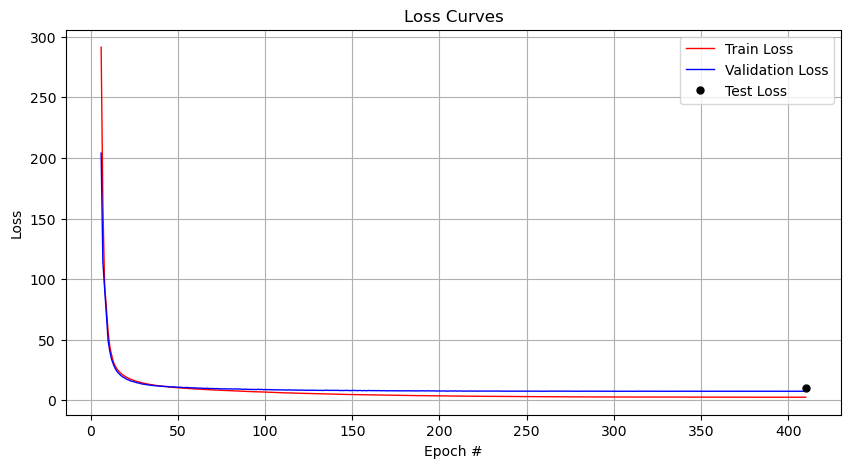

In [ ]:
#taking a look at the loss curve
loss_fig = plt.figure(figsize=(10,5))

#full Loss Curve, (I am omitting first N epochs)
linewidth = 1
test_point_size = 10 #size of the test point
omit_epochs = 5 #number of epochs to omit from the start of the curve
if omit_epochs >= num_epochs:
    raise ValueError('Omit epochs must be less than number of epochs')

plt.plot(np.array(range(num_epochs))[omit_epochs:] + 1, model_history['train_loss'][omit_epochs:], '-r', label='Train Loss', linewidth=linewidth)
plt.plot(np.array(range(num_epochs))[omit_epochs:] + 1, model_history['val_loss'][omit_epochs:], '-b', label='Validation Loss', linewidth=linewidth)
plt.plot(num_epochs, model_history['test_loss'], '.k', markersize=test_point_size, label='Test Loss')
plt.xlabel('Epoch #'); plt.ylabel('Loss')
plt.title('Loss Curves')
plt.grid()
plt.legend()
plt.show()

**Question 2:**

make a convolutional neural network for classification.

You should use the Fashion-MNIST dataset that can be loaded with the following sample code.

get a 5-fold KFold cross-validated accuracy of at least **93.5%** on a test size of **20%**.

You may use PyTorch for the neural network, Pandas and scikit-learn for reading in the data, preprocessing, and KFold, and NumPy and PyTorch for everything else.

In [ ]:
#import code from active coding CNNs section 01
import torchvision
import torchvision.transforms as transforms

#we need to choose a data set for convolutions
#define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#download and load the training and test datasets
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
#tweaked batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=80, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=80, shuffle=False)

Shape of X [N, C, H, W]: torch.Size([80, 1, 28, 28])
Shape of y: torch.Size([80]) torch.int64


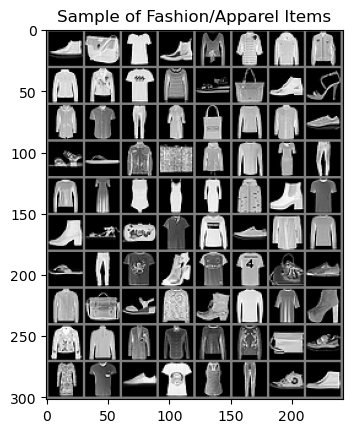

First Label: Sneaker


In [ ]:
#setup code from active coding CNNs section 01
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
#define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#function to display images
def imshow(img, label):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Sample of Fashion/Apparel Items')
    #plt.title(f'First Item: {class_names[label]}')
    plt.show()

#get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

#show images
imshow(torchvision.utils.make_grid(images), labels[0])

#display the name of the label for the first image in the batch
print(f'First Label: {class_names[labels[0]]}')


In [ ]:
class FashCNN(nn.Module):
    def __init__(self):
        super(FashCNN,self).__init__()
        #build the first layer of convolutions
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,padding=1,stride=1),
            #batch normalization means scaling the output from convolutions
            nn.BatchNorm2d(64),
            nn.ReLU(), #activations
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding=1,stride=1),
            #batch normalization means scaling the output from convolutions
            nn.BatchNorm2d(64),
            nn.ReLU(), #activations
            nn.MaxPool2d(kernel_size=2,stride=1),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        flat_features = 128 * 25 * 25

        self.fc1 = nn.Linear(flat_features, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
#without kfold and test size of .20 - based off the active coding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:' , {device})
model = FashCNN().to(device)

#define loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # it's a must: choose the correct loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.006) # we chose adaptive momentum gradient descent as our optimizer

#train model
num_epochs = 10 #has 12 in notes, tried with different vals

#connects images to the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        #backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#print results and track
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


#evaluate the model
model.eval()  #set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Using device: {device(type='cuda')}
Epoch [1/10], Step [100/750], Loss: 3.0166
Epoch [1/10], Step [200/750], Loss: 0.6385
Epoch [1/10], Step [300/750], Loss: 0.5400
Epoch [1/10], Step [400/750], Loss: 0.6975
Epoch [1/10], Step [500/750], Loss: 0.7793
Epoch [1/10], Step [600/750], Loss: 0.4698
Epoch [1/10], Step [700/750], Loss: 0.2834
Epoch [2/10], Step [100/750], Loss: 0.5626
Epoch [2/10], Step [200/750], Loss: 0.5791
Epoch [2/10], Step [300/750], Loss: 0.2358
Epoch [2/10], Step [400/750], Loss: 0.3235
Epoch [2/10], Step [500/750], Loss: 0.2242
Epoch [2/10], Step [600/750], Loss: 0.5291
Epoch [2/10], Step [700/750], Loss: 0.3080
Epoch [3/10], Step [100/750], Loss: 0.4362
Epoch [3/10], Step [200/750], Loss: 0.2684
Epoch [3/10], Step [300/750], Loss: 0.2540
Epoch [3/10], Step [400/750], Loss: 0.2997
Epoch [3/10], Step [500/750], Loss: 0.2696
Epoch [3/10], Step [600/750], Loss: 0.2767
Epoch [3/10], Step [700/750], Loss: 0.1537
Epoch [4/10], Step [100/750], Loss: 0.3128
Epoch [4/10], Step

**Question 3**

You should use the winemagdata130kv2 dataset from https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/winemagdata130kv2.csv with "points" as the target to build two different models, one of which is a neural network and the other of which is your choice (but not another neural network).

You may use PyTorch for the neural network, Pandas for reading in the data, Matplotlib for plotting (if you deem it necessary), and NumPy, scikit-learn, and PyTorch for everything else.

The 5-fold KFold cross-validated MSE for each model should be below 4.

Hint: You will almost certainly need to use NLP methods from class to turn the data into a viable format for your models!

In [ ]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import download, wordnet
nltk.download('omw-1.4')
download('stopwords')
download("wordnet")
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/selozina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/selozina/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/selozina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/selozina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
url = 'https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/winemagdata130kv2.csv'
wine = pd.read_csv(url)
wine.head()

In [ ]:
#Function from class notes for fast pre processing
def fast_preprocess(texts, lemmatize=True):
   #handle single string input
   single_input = isinstance(texts, str)
   if single_input:
       texts = [texts]

   stop_words = set(stopwords.words('english'))

   #create translator for punctuation removal (faster than regex for this task)
   translator = str.maketrans('', '', string.punctuation)

   #initialize lemmatizer if needed
   lemmatizer = WordNetLemmatizer() if lemmatize else None

   processed_texts = []
   for text in texts:
       #lowercase
       text = text.lower()
       #remove punctuation
       text = text.translate(translator)
       #tokenize (needed for both stopword removal and lemmatization)
       tokens = text.split()
       #remove stopwords
       tokens = [token for token in tokens if token not in stop_words]
       #lemmatize if requested
       if lemmatize:
           tokens = [lemmatizer.lemmatize(token) for token in tokens]
       #rejoin into text
       processed_texts.append(' '.join(tokens))
   #return in same format as input
   return processed_texts[0] if single_input else processed_texts

In [ ]:
reviews = fast_preprocess(wine['description'])
embedding = TfidVectorizer(max_features = 1000)

X = embedding.fit_transform(reviews)
y = wine['points'].values

In [ ]:
#Model 1 = linear regression
#set up Kfold validation
kf = KFold(n_splits=5, shuffle=True)

#initialize the model
model = LinearRegression()

#store the MSEs
mse_tracker = []

#loop through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #fit the model on training data
    model.fit(X_train, y_train)

    #predict on test data
    y_pred = model.predict(X_test)

    #compute MSE and store it
    mse = mean_squared_error(y_test, y_pred)
    mse_tracker.append(mse)

#compute average MSE across all folds
mse_avg = np.mean(mse_tracker)
print(f"Average 5-fold MSE: {mse_avg:.4f}")

Average 5-fold MSE: 3.4491


In [ ]:
url = 'https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/winemagdata130kv2.csv'
wine = pd.read_csv(url)
wine.head()

#drop NA and reset the index
wine = wine.dropna().reset_index(drop=True)
#drop unnamed column
wine = wine.loc[:, ~wine.columns.str.contains('^Unnamed')]

#drop country and taster_twitter_handle columns and price
wine = wine.drop(['country', 'taster_twitter_handle', 'price'], axis=1)
wine.head()
#keep taster, region1, region2, provence, variety

,description,designation,points,province,region_1,region_2,taster_name,title,variety,winery
0,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
1,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,California,Napa Valley,Napa,Virginie Boone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
2,This wine from the Geneseo district offers aro...,Signature Selection,87,California,Paso Robles,Central Coast,Matt Kettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
3,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,California,Sonoma Coast,Sonoma,Virginie Boone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
4,As with many of the Erath 2010 vineyard design...,Hyland,86,Oregon,McMinnville,Willamette Valley,Paul Gregutt,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath


In [ ]:
#preprocess all text columns
description = fast_preprocess(wine['description'].tolist())
designation = fast_preprocess(wine['designation'].tolist())
title = fast_preprocess(wine['title'].tolist())
winery = fast_preprocess(wine['winery'].tolist())
province = fast_preprocess(wine['province'].tolist())
region_1 = fast_preprocess(wine['region_1'].tolist())
region_2 = fast_preprocess(wine['region_2'].tolist())

#vectorize the text columns with TF-IDF
#NOTE: do not scale vectorized features
descrip_embedding = TfidfVectorizer(max_features=256) #set max features to avoid overfitting
desig_embedding = TfidfVectorizer(max_features=256)
title_embedding = TfidfVectorizer(max_features=256)
winery_embedding = TfidfVectorizer(max_features=256)
prov_embedding = TfidfVectorizer(max_features=256)
reg1_embedding = TfidfVectorizer(max_features=256)
reg2_embedding = TfidfVectorizer(max_features=256)


description_tfidf = descrip_embedding.fit_transform(description).toarray()
designation_tfidf = desig_embedding.fit_transform(designation).toarray()
title_tfidf = title_embedding.fit_transform(title).toarray()
winery_tfidf = winery_embedding.fit_transform(winery).toarray()
province_tfidf = prov_embedding.fit_transform(province).toarray()
region_1_tfidf = reg1_embedding.fit_transform(region_1).toarray()
region_2_tfidf = reg2_embedding.fit_transform(region_2).toarray()

In [ ]:
#combine all features for X variable but drop points
X = np.hstack([description_tfidf, designation_tfidf, title_tfidf, winery_tfidf, province_tfidf, region_1_tfidf, region_2_tfidf])
y = wine['points'].values

In [ ]:
#define a simple neural network
class WineNet(nn.Module):
   def __init__(self, n_features):
       super().__init__()
       self.model = nn.Sequential(
         #defining the topology - made deeper with 4 layers
         nn.Linear(n_features, 64), # layer 1
         nn.PReLU(), #activation function 1
         nn.Linear(64, 32), # layer 2
         nn.PReLU(), #activation function 2
         nn.Linear(32, 16), # layer 3
         nn.PReLU(), #activation function 3
         nn.Linear(16, 8), # layer 4
         nn.PReLU(), #activation function 4
         nn.Linear(8,1) #output layer with 1 neuron for regression
         )

   def forward(self, x):
     return self.model(x)

In [ ]:
#set and display device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing Device: '{device}'")

#hyperparameters
n_epochs = 100 # number of epochs
batch_size = 50 # batch size
learning_rate = .01 # learning rate -> made higher
min_lr = 1e-8 # minimum learning rate
weight_decay = 0.01 # weight decay
n_splits = 5 # number of folds for kfold cross val
val_percent = 0.26

#store loss scores
total_loss_scores = []

#setup KFold cross-validation object
kf = KFold(n_splits=n_splits, shuffle=True)

#loop through each fold
for fold, (trainval_idx, test_idx) in enumerate(kf.split(X)):
 # Print the fold number
 print(f"\nFold {fold + 1}/{n_splits}")

 #split data into training/val and testing sets
 X_trainval, X_test = X[trainval_idx], X[test_idx]
 y_trainval, y_test = y[trainval_idx], y[test_idx]

 #split training data into training and validation sets
 X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_percent, shuffle=True)

 #convert to torch tensors
 X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
 y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
 X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
 y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)
 X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
 y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

 #create TensorDatasets
 train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
 val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
 test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)
 print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


 #create DataLoader for training and testing
 train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
 test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

 #initialize model and send to device
 model = WineNet(n_features=X.shape[1])
 model = model.to(device)

 #loss function and optimizer
 criterion = nn.MSELoss() # Loss function
 optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
 #control learning rate decay
 scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=min_lr)

 #set up loss storage
 loss_scores = {
                 'train_loss': [], #training loss
                 'val_loss': [], #validation loss
                 'test_loss': []}  #testing loss

 #training loop
 for epoch in range(n_epochs):
   print(f"Starting Epoch {epoch+1}")
   model.train() #put model in training state
   train_loss = 0.0 #set training loss to zero
   for X_batch, y_batch in train_loader:
     #put data back on device
     X_batch, y_batch = X_batch.to(device), y_batch.to(device)
     #reset optimizer before each new calculation
     optimizer.zero_grad() #zero the gradients
     #forward propagation
     outputs = model(X_batch)
     #use the criterion to compute the loss of the batch
     t_loss = criterion(outputs, y_batch)
     #backpropogation
     t_loss.backward() #approximation of the gradient
     optimizer.step() #actual update of weights with algorithm chosen
     train_loss += t_loss.item()*len(X_batch)
   scheduler.step() #update learning rate

   #training loss results
   train_loss /= len(train_loader.dataset) # Divide by number of samples to get average loss
   loss_scores['train_loss'].append(train_loss) # Store training loss

   #validation loss computation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
     for X_batch, y_batch in val_loader:
       X_batch, y_batch = X_batch.to(device), y_batch.to(device)
       outputs = model(X_batch)
       v_loss = criterion(outputs, y_batch)
       val_loss += v_loss.item()*len(X_batch)

   #validation loss results
   val_loss /= len(val_loader.dataset) # Divide by number of samples to get average loss
   loss_scores['val_loss'].append(val_loss) # Store validation loss

   #display results on first epoch and every N epochs
   if epoch == 0 or (epoch + 1) % 100 == 0:
       print(f'Epoch [{epoch+1:5.0f}/{n_epochs:5.0f}], Train Loss: {train_loss:9.4f}, Val Loss: {val_loss:9.4f}')

 #use trained model to predict test set
 model.eval()
 test_loss = 0.0
 with torch.no_grad():
   for X_batch, y_batch in test_loader:
     # Put data back on device
     X_batch, y_batch = X_batch.to(device), y_batch.to(device)
     outputs = model(X_batch)
     t_loss = criterion(outputs, y_batch)
     test_loss += t_loss.item()*len(X_batch)

 #testing Results
 test_loss /= len(test_loader.dataset)
 print(f'Test Loss: {test_loss:.4f}')
 loss_scores['test_loss'] = test_loss # Store test loss

 total_loss_scores.append(loss_scores) # Store history of each fold


#calculate average loss
avg_train_loss = np.mean([fold['train_loss'] for fold in total_loss_scores], axis = 0) # Average training loss
avg_val_loss = np.mean([fold['val_loss'] for fold in total_loss_scores], axis = 0) # Average val loss
avg_test_loss = np.mean([fold['test_loss'] for fold in total_loss_scores], axis = 0) # Average testing loss

#print final results
print(f'Average Test Loss: {avg_test_loss:.4f}')


Using Device: 'cuda'

Fold 1/5
Train size: 13252, Val size: 4657
Starting Epoch 1
Epoch [    1/  100], Train Loss:  548.7801, Val Loss:   19.5626
Starting Epoch 2
Starting Epoch 3
Starting Epoch 4
Starting Epoch 5
Starting Epoch 6
Starting Epoch 7
Starting Epoch 8
Starting Epoch 9
Starting Epoch 10
Starting Epoch 11
Starting Epoch 12
Starting Epoch 13
Starting Epoch 14
Starting Epoch 15
Starting Epoch 16
Starting Epoch 17
Starting Epoch 18
Starting Epoch 19
Starting Epoch 20
Starting Epoch 21
Starting Epoch 22
Starting Epoch 23
Starting Epoch 24
Starting Epoch 25
Starting Epoch 26
Starting Epoch 27
Starting Epoch 28
Starting Epoch 29
Starting Epoch 30
Starting Epoch 31
Starting Epoch 32
Starting Epoch 33
Starting Epoch 34
Starting Epoch 35
Starting Epoch 36
Starting Epoch 37
Starting Epoch 38
Starting Epoch 39
Starting Epoch 40
Starting Epoch 41
Starting Epoch 42
Starting Epoch 43
Starting Epoch 44
Starting Epoch 45
Starting Epoch 46
Starting Epoch 47
Starting Epoch 48
Starting Epoch 

**Question 4**

You will import the given loan status classification data from https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/loan_data.csv and use preprocessing (of your choice) and classification models to predict the "loan_status". The input features are the rest of the columns.

The goal is for you to build two different models using libraries taught in class (e.g. scikit-learn, PyTorch, NumPy, etc.) that each achive at least 97% ROC and 93.5% 5-fold cross validated (your choice of KFold or StratifiedKFold) accuracy for predicting the test sets.

At least one of the models has to be a type that is not used in any other question (for example, if you use a NN and an SVM for Q3, you can only use either a NN or an SVM for Q4

Write a few sentences explaining why you chose each type of model.

In [ ]:
url = 'https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/loan_data.csv'
loan = pd.read_csv(url)
loan.head()
#have some categorical columns need to update!

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay,auc, roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, RocCurveDisplay, roc_auc_score
from sklearn import neighbors

In [ ]:
#use one hot encoder to transform categorical data into a numerical format
categorical_columns = loan.select_dtypes(include = ['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder.fit_transform(loan[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_columns))
loans = pd.concat([loan, one_hot_df], axis=1)
loans = loans.drop(categorical_columns, axis=1)
loans.head()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_female,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
0,22.0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,21.0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,25.0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,23.0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,24.0,66135.0,1,35000.0,14.27,0.53,4.0,586,1,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


source for one hot encoder: https://www.geeksforgeeks.org/ml-one-hot-encoding/

In [ ]:
#bit of a class imbalance
count_0 = (loans['loan_status'] == 0).sum()
count_1 = (loans['loan_status'] == 1).sum()
print(count_0, count_1)

35000 10000


source for determining counts of 0 and 1, determining if class imbalance https://www.geeksforgeeks.org/how-to-count-occurrences-of-specific-value-in-pandas-column/

In [ ]:
y = loans['loan_status'].values
X = loans.drop(columns=['loan_status']).values

Chose Random Forest because it is resistant to noise and outliers, is able to manage high-dimensional datasets effectively. We also thought multiple decision trees would yield higher accuracy than a single decision tree since Random Forest aggregates the predictions of many decision trees. Furthermore, Random Forest does not require data preprocessing.

Chose Gradient Boosting Classifier because it was recommended during office hours. Gradient boosting is also an ensemble model that combines weak models, such as decision trees. The algorithm works iteratively by adding new models sequentially with each new addition added with the goal of reducing the errors and bias of the previous. Additionally, it was very quick at training on our larger dataset.

Tried KNN and the accuracy was not high enough. Additionally, stratified kfold performed worse than kfold so proceeded with kfold.

sources: https://www.geeksforgeeks.org/what-are-the-advantages-and-disadvantages-of-random-forest/ AND https://www.snowflake.com/guides/what-gradient-boosting/

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [ ]:
#model 1: gradient boosting classifier
#recommended in OH
#hyperparameters
n_estimators = 500 # 100, 200, 300
max_depth = 5 # None 10 20 30
min_samples_split = 2 # 2 5 10 -> does not have any effect on score
min_samples_leaf = 1 # 1 2 4 -> does not have any effect on score

#set up Stratified Kfold validation
kf = KFold(n_splits=5, shuffle=True)
model1 = GradientBoostingClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=0.5,
                                       criterion='friedman_mse') # adjust for class imbalance

#tracking accuracy and ROC score
acc_scores = []
roc_scores = []

#loop through each fold
for train_index, test_index in kf.split(X, y):
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

   scaler = StandardScaler()
   X_train = scaler.fit_transform(X_train)
   X_test = scaler.transform(X_test)

   #fit the model on training data
   model1.fit(X_train, y_train.ravel())

   #predict on test data
   y_pred = model1.predict(X_test)
   y_prob = model1.predict_proba(X_test)[:, 1]

   #compute accuracy and store it
   acc_scores.append(accuracy_score(y_test, y_pred))
   roc_scores.append(roc_auc_score(y_test, y_prob))

#compute average MSE across all folds
acc_avg = np.mean(acc_scores)
roc_avg = np.mean(roc_scores)
print(f"Average 5-fold Accuracy: {acc_avg:.4f}")
print(f"Average 5-fold ROC Score: {roc_avg:.4f}")

Average 5-fold Accuracy: 0.9374
Average 5-fold ROC Score: 0.9803


In [ ]:
#model 2: random forest classifier
#hyperparameters
n_estimators = 300
max_depth = 30
min_samples_split = 2
min_samples_leaf = 1
max_features = 'sqrt'

#set up Kfold validation
kf = KFold(n_splits=5, shuffle = True)
model1 = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=.5, criterion = 'entropy',
                                bootstrap = False, class_weight='balanced')

#tracking accuracy and ROC score
acc_scores = []
roc_scores = []

#random forest does not require scaling
#loop through each fold
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #fit the model on training data
    model1.fit(X_train, y_train)

    #predict on test data
    y_pred = model1.predict(X_test)
    y_prob = model1.predict_proba(X_test)[:, 1]

    #compute accuracy and store it
    acc_scores.append(accuracy_score(y_test, y_pred))
    roc_scores.append(roc_auc_score(y_test, y_prob))

#compute average MSE across all folds
acc_avg = np.mean(acc_scores)
roc_avg = np.mean(roc_scores)
print(f"Average 5-fold Accuracy: {acc_avg:.4f}")
print(f"Average 5-fold ROC Score: {roc_avg:.4f}")

Average 5-fold Accuracy: 0.9322
Average 5-fold ROC Score: 0.9765


source for understanding random forests hyperparameters: https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/

source for roc_auc_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html